In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("f1_training_dataset_2018_2024.csv")
pd.options.display.max_rows = 200

print("ROWS / YEARS / UNIQUE RACES / DRIVERS")
print("rows:", len(df))
print("years:", sorted(df['race_year'].dropna().unique()))
print("unique race_key:", df['race_key'].nunique())
print("unique drivers:", df['driver'].nunique())
print()

# 1) Critical columns present
critical = ['race_key','race_year','event','circuit','driver','team',
            'qualifying_position','finishing_position','event_date']
miss = [c for c in critical if c not in df.columns]
print("missing critical cols:", miss)
print()

# 2) DTypes + nulls summary
print("dtypes and null counts:")
print(df[critical + ['qualifying_lap_time_s','race_lap_time_s','dnf']].dtypes)
print(df[critical + ['qualifying_lap_time_s','race_lap_time_s','dnf']].isna().sum())
print()

# 3) Value ranges sanity
print("qualifying_position min/max:", df['qualifying_position'].min(), df['qualifying_position'].max())
print("finishing_position min/max:", df['finishing_position'].min(), df['finishing_position'].max())
print("qualifying_position null %:", df['qualifying_position'].isna().mean())
print("finishing_position null %:", df['finishing_position'].isna().mean())
print()

# 4) Duplicates: one row per race_key+driver
dups = df.duplicated(subset=['race_key','driver']).sum()
print("duplicate (race_key,driver) rows:", dups)
if dups>0:
    print("examples:")
    print(df[df.duplicated(subset=['race_key','driver'], keep=False)].sort_values(['race_key','driver']).head(20))
print()

# 5) Check event counts per year vs expected F1 calendar rough check
counts = df.groupby('race_year')['race_key'].nunique().sort_index()
print("races per year (unique race_key):")
print(counts)
print()

# 6) Finish distribution (helps spot mapping issues)
print("finish position distribution (counts):")
print(df['finishing_position'].value_counts(dropna=False).sort_index())
print()

# 7) DNFs and finish rate
if 'dnf' in df.columns:
    print("DNF counts:", df['dnf'].value_counts(dropna=False))
    finish_rate = (df['dnf']==0).sum() / len(df)
    print("finish rate:", finish_rate)
print()

# 8) Event dates validity
print("sample earliest/latest event dates:", df['event_date'].min(), df['event_date'].max())
bad_dates = pd.to_datetime(df['event_date'], errors='coerce').isna().sum()
print("invalid event_date entries:", bad_dates)


In [23]:
# akhri yehi sachi training file train_spencer_final_patched.py
"""
Spencer-style final training pipeline (patched)
- Binary targets: winner (P1) and podium (P1-P3)
- Conservative fallback feature engineering if engineered columns absent
- GroupKFold by race_year for realistic CV
- No early stopping (compatibility)
- Saves models and metadata for inference
"""

import os
import logging
from typing import Tuple, Dict, Any
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import joblib

# -----------------------
# CONFIG
# -----------------------
DATA_CSV = "f1_training_dataset_2018_2024.csv"
OUT_DIR = "models_spencer"
WINNER_MODEL_FILE = os.path.join(OUT_DIR, "xgb_winner.joblib")
PODIUM_MODEL_FILE = os.path.join(OUT_DIR, "xgb_podium.joblib")
METADATA_FILE = os.path.join(OUT_DIR, "metadata.joblib")
RANDOM_STATE = 42
N_SPLITS = 5  # GroupKFold by race_year
# -----------------------

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
log = logging.getLogger("spencer_final")

# -----------------------
# FIXED FEATURE SET (Spencer minimal)
# -----------------------
NUM_FEATURES = [
    "qualifying_position",
    "TeamPerfScore",
    "EloRating",
    "RecentFormAvg",
    "CircuitHistoryAvg",
    "DriverExperienceScore",
]
CAT_FEATURES = ["driver", "team", "circuit"]  # simple label encodings
# -----------------------


def compute_basic_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Conservative fallbacks for missing engineered features:
    - TeamPerfScore: per-season team mean finishing_position inverted & normalized 0-1
    - EloRating: default 1500
    - RecentFormAvg: driver's rolling mean finishing_position (shifted) over last 5 races (no leakage)
    - CircuitHistoryAvg: driver's historical avg at circuit (shifted)
    - DriverExperienceScore: normalized number of prior races (cumcount normalized)
    All computations avoid using the target for the same race (shifted where necessary).
    """
    # ensure event_date is datetime for ordering
    df["event_date"] = pd.to_datetime(df.get("event_date", pd.NaT), errors="coerce")
    df = df.sort_values(["driver", "race_year", "event_date"]).reset_index(drop=True)

    # Elo simple fallback (static)
    if "EloRating" not in df.columns or df["EloRating"].isna().all():
        df["EloRating"] = 1500.0

    # RecentFormAvg (shifted rolling mean of finishing_position)
    df["finishing_position_num"] = pd.to_numeric(df["finishing_position"], errors="coerce")
    df["RecentFormAvg"] = (
        df.groupby("driver")["finishing_position_num"]
          .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
    )
    median_fin = df["finishing_position_num"].median()
    df["RecentFormAvg"] = df["RecentFormAvg"].fillna(median_fin)

    # CircuitHistoryAvg (shifted expanding mean per driver-circuit)
    df["CircuitHistoryAvg"] = (
        df.groupby(["driver", "circuit"])["finishing_position_num"]
          .transform(lambda x: x.shift(1).expanding(min_periods=1).mean())
    )
    df["CircuitHistoryAvg"] = df["CircuitHistoryAvg"].fillna(median_fin)

    # DriverExperienceScore: total prior races normalized
    df["TotalRaces"] = df.groupby("driver").cumcount()  # prior races count
    max_r = df["TotalRaces"].max() if df["TotalRaces"].notna().any() else 1
    df["DriverExperienceScore"] = (df["TotalRaces"] / max_r).fillna(0.0)

    # TeamPerfScore: per-season team mean finishing position inverted -> normalize 0-1
    df["fin_pos_for_team"] = df["finishing_position_num"]
    team_season = (
        df.dropna(subset=["fin_pos_for_team"])
          .groupby(["race_year", "team"])
          ["fin_pos_for_team"]
          .mean()
          .reset_index()
          .rename(columns={"fin_pos_for_team": "team_mean_fin"})
    )
    df = df.merge(team_season, on=["race_year", "team"], how="left")
    if df["team_mean_fin"].notna().any():
        # normalize per year so TeamPerfScore in [0,1]
        df["TeamPerfScore"] = df.groupby("race_year")["team_mean_fin"].transform(
            lambda x: (x.max() - x) / (x.max() - x.min()) if x.max() != x.min() else 0.5
        )
    else:
        df["TeamPerfScore"] = 0.5

    # drop helpers
    df.drop(columns=["finishing_position_num", "fin_pos_for_team", "team_mean_fin"], inplace=True, errors="ignore")

    # fill any remaining NaNs conservatively
    for c in ["TeamPerfScore", "EloRating", "RecentFormAvg", "CircuitHistoryAvg", "DriverExperienceScore"]:
        if c not in df.columns:
            df[c] = 0.0
        else:
            df[c] = df[c].fillna(df[c].median())

    return df


def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    log.info(f"Loaded {len(df)} rows from {path}")

    # Keep only rows with finishing position (required for labels)
    df = df[df["finishing_position"].notna()].copy()
    log.info(f"After dropping rows without finishing_position: {len(df)} rows")

    # Ensure numeric feature columns exist (may be missing from CSV)
    for c in NUM_FEATURES:
        if c not in df.columns:
            log.warning(f"{c} missing in CSV — will compute conservative fallback")
            df[c] = np.nan

    # Ensure categorical columns exist
    for c in CAT_FEATURES:
        if c not in df.columns:
            log.warning(f"{c} missing in CSV — creating 'Unknown'")
            df[c] = "Unknown"

    # Compute conservative engineered fallbacks (no leakage)
    df = compute_basic_engineering(df)

    # Drop rows that still miss qualifying_position or finishing_position
    df = df[df["qualifying_position"].notna() & df["finishing_position"].notna()].copy()
    log.info(f"After ensuring qualifying_position & finishing_position present: {len(df)} rows")

    df.reset_index(drop=True, inplace=True)
    return df


def prepare_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, LabelEncoder], pd.Series, pd.Series]:
    # Label targets
    df["is_winner"] = (df["finishing_position"] == 1).astype(int)
    df["is_podium"] = (df["finishing_position"] <= 3).astype(int)

    # Fill numeric features with medians (conservative)
    for col in NUM_FEATURES:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        median = df[col].median()
        df[col] = df[col].fillna(median)
        log.debug(f"Filled {col} NaN with median={median}")

    # Simple LabelEncoders for categorical values
    encoders: Dict[str, LabelEncoder] = {}
    for c in CAT_FEATURES:
        le = LabelEncoder()
        df[c] = df[c].fillna("Unknown").astype(str)
        df[f"{c}_enc"] = le.fit_transform(df[c])
        encoders[c] = le

    feature_cols = NUM_FEATURES + [f"{c}_enc" for c in CAT_FEATURES]
    X = df[feature_cols].copy()
    y_win = df["is_winner"].copy()
    y_pod = df["is_podium"].copy()
    log.info(f"Prepared feature matrix with columns: {feature_cols}")
    return X, encoders, y_win, y_pod


def train_xgb_classifier(
    X: pd.DataFrame, y: pd.Series, groups: pd.Series, model_path: str
) -> Dict[str, Any]:
    # GroupKFold by seasons to avoid leakage
    unique_groups = np.unique(groups)
    n_splits = min(N_SPLITS, len(unique_groups)) if len(unique_groups) > 1 else 1
    gkf = GroupKFold(n_splits=n_splits)

    fold_metrics = []
    oof_preds = np.zeros(len(y))
    fold = 0

    params = dict(
        n_estimators=250,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
    )

    for train_idx, val_idx in gkf.split(X, y, groups):
        fold += 1
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # handle class imbalance with scale_pos_weight (safe heuristic)
        pos = y_tr.sum()
        neg = len(y_tr) - pos
        scale_pos_weight = (neg / pos) if pos > 0 else 1.0
        clf = xgb.XGBClassifier(**params, scale_pos_weight=scale_pos_weight)

        # NOTE: compatibility — no early_stopping here
        clf.fit(X_tr, y_tr)

        p_val = clf.predict_proba(X_val)[:, 1]
        preds = (p_val >= 0.5).astype(int)

        acc = accuracy_score(y_val, preds)
        prec = precision_score(y_val, preds, zero_division=0)
        rec = recall_score(y_val, preds, zero_division=0)
        f1 = f1_score(y_val, preds, zero_division=0)
        auc = roc_auc_score(y_val, p_val) if len(np.unique(y_val)) > 1 else float("nan")

        fold_metrics.append({"fold": fold, "acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc})
        oof_preds[val_idx] = p_val

        log.info(f"Fold {fold}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}, auc={auc:.4f}")

    # Fit final model on all data
    pos = y.sum()
    neg = len(y) - pos
    scale_pos_weight = (neg / pos) if pos > 0 else 1.0
    final_clf = xgb.XGBClassifier(**params, scale_pos_weight=scale_pos_weight)
    final_clf.fit(X, y)

    # Save the classifier
    os.makedirs(OUT_DIR, exist_ok=True)
    joblib.dump({"model": final_clf}, model_path)
    log.info(f"Saved final model to {model_path}")

    # Summarize CV metrics
    dfm = pd.DataFrame(fold_metrics) if fold_metrics else pd.DataFrame()
    summary = dfm.mean().to_dict() if not dfm.empty else {}
    log.info(f"CV mean metrics: {summary}")

    return {"model": final_clf, "oof_preds": oof_preds, "cv_summary": summary}


def train_and_save(df: pd.DataFrame):
    X, encoders, y_win, y_pod = prepare_features(df)
    groups = df["race_year"].fillna(-1).astype(int)

    # Train winner model
    log.info("Training winner model")
    res_win = train_xgb_classifier(X, y_win, groups, WINNER_MODEL_FILE)

    # Train podium model
    log.info("Training podium model")
    res_pod = train_xgb_classifier(X, y_pod, groups, PODIUM_MODEL_FILE)

    # Save encoders and feature list (metadata)
    metadata = {"feature_cols": X.columns.tolist(), "encoders": encoders}
    joblib.dump(metadata, METADATA_FILE)
    log.info(f"Saved metadata to {METADATA_FILE}")

    # Simple overall OOF summary
    def summarize(oof, y, label):
        preds = (oof >= 0.5).astype(int)
        return {
            "accuracy": accuracy_score(y, preds),
            "precision": precision_score(y, preds, zero_division=0),
            "recall": recall_score(y, preds, zero_division=0),
            "f1": f1_score(y, preds, zero_division=0),
            "auc": roc_auc_score(y, oof) if len(np.unique(y)) > 1 else float("nan"),
        }

    win_summary = summarize(res_win["oof_preds"], y_win, "winner (OOF)")
    pod_summary = summarize(res_pod["oof_preds"], y_pod, "podium (OOF)")
    log.info(f"Winner OOF summary: {win_summary}")
    log.info(f"Podium OOF summary: {pod_summary}")


def infer_race(race_key: str, csv_path: str = DATA_CSV) -> pd.DataFrame:
    """
    Returns a DataFrame (driver, team, p_win, p_podium) ranked by p_win descending.
    Uses saved models + metadata.
    """
    if not os.path.exists(METADATA_FILE):
        raise FileNotFoundError("Metadata file not found. Train models first.")

    meta = joblib.load(METADATA_FILE)
    model_win = joblib.load(WINNER_MODEL_FILE)["model"]
    model_pod = joblib.load(PODIUM_MODEL_FILE)["model"]
    encoders = meta["encoders"]
    feature_cols = meta["feature_cols"]

    df_all = pd.read_csv(csv_path)
    df_r = df_all[df_all["race_key"] == race_key].copy()
    if df_r.empty:
        raise ValueError(f"No rows found for race_key={race_key}")

    # compute conservative engineered features to match training
    df_r = compute_basic_engineering(df_r)

    # Ensure numeric features and fill medians
    for col in NUM_FEATURES:
        if col not in df_r.columns:
            df_r[col] = np.nan
        df_r[col] = pd.to_numeric(df_r[col], errors="coerce")
        df_r[col] = df_r[col].fillna(df_r[col].median())

    # encode cats using stored encoders; unseen labels -> mapped to new integer (len(classes))
    for c in CAT_FEATURES:
        df_r[c] = df_r[c].fillna("Unknown").astype(str)
        le: LabelEncoder = encoders[c]
        classes = list(le.classes_)
        mapped = []
        for v in df_r[c].tolist():
            if v in classes:
                mapped.append(int(classes.index(v)))
            else:
                mapped.append(len(classes))  # unseen label mapping
        df_r[f"{c}_enc"] = mapped

    X_race = df_r[feature_cols].copy()
    p_win = model_win.predict_proba(X_race)[:, 1]
    p_pod = model_pod.predict_proba(X_race)[:, 1]

    out = df_r[["driver", "team"]].copy()
    out["p_win"] = p_win
    out["p_podium"] = p_pod
    out = out.sort_values("p_win", ascending=False).reset_index(drop=True)
    return out


def main():
    df = load_and_clean(DATA_CSV)
    train_and_save(df)
    log.info("Training complete. Models and metadata saved in 'models_spencer' directory.")
    # print a sample race_key for quick inference testing
    sample_race = df["race_key"].unique()[0]
    log.info(f"To run inference on a race, call infer_race(race_key='{sample_race}') in Python environment.")


if __name__ == "__main__":
    main()


2025-11-20 15:10:57,691 | INFO | Loaded 3119 rows from f1_training_dataset_2018_2024.csv
2025-11-20 15:10:57,699 | INFO | After dropping rows without finishing_position: 3116 rows
2025-11-20 15:10:57,701 | WARNING | TeamPerfScore missing in CSV — will compute conservative fallback
2025-11-20 15:10:57,712 | WARNING | EloRating missing in CSV — will compute conservative fallback
2025-11-20 15:10:57,713 | WARNING | RecentFormAvg missing in CSV — will compute conservative fallback
2025-11-20 15:10:57,715 | WARNING | CircuitHistoryAvg missing in CSV — will compute conservative fallback
2025-11-20 15:10:57,717 | WARNING | DriverExperienceScore missing in CSV — will compute conservative fallback
2025-11-20 15:10:58,881 | INFO | After ensuring qualifying_position & finishing_position present: 3113 rows
2025-11-20 15:10:58,898 | INFO | Prepared feature matrix with columns: ['qualifying_position', 'TeamPerfScore', 'EloRating', 'RecentFormAvg', 'CircuitHistoryAvg', 'DriverExperienceScore', 'drive

In [ ]:
import pandas as pd
import joblib
import numpy as np

# load
df = pd.read_csv("f1_training_dataset_2018_2024.csv")
meta = joblib.load("models_spencer/metadata.joblib")
model_win = joblib.load("models_spencer/xgb_winner.joblib")["model"]
model_pod = joblib.load("models_spencer/xgb_podium.joblib")["model"]
feature_cols = meta["feature_cols"]
encoders = meta["encoders"]

# Fixed local engineering (ffill instead of deprecated fillna(method=...))
def compute_basic_engineering_local(df_loc):
    df_loc = df_loc.copy()
    df_loc["event_date"] = pd.to_datetime(df_loc.get("event_date", pd.NaT), errors="coerce")
    df_loc = df_loc.sort_values(["driver","race_year","event_date"]).reset_index(drop=True)

    df_loc["finishing_position_num"] = pd.to_numeric(df_loc["finishing_position"], errors="coerce")
    median_fin = df_loc["finishing_position_num"].median()

    df_loc["RecentFormAvg"] = df_loc.groupby("driver")["finishing_position_num"] \
                                    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
    df_loc["RecentFormAvg"] = df_loc["RecentFormAvg"].fillna(median_fin)

    df_loc["CircuitHistoryAvg"] = df_loc.groupby(["driver","circuit"])["finishing_position_num"] \
                                       .transform(lambda x: x.shift(1).expanding(min_periods=1).mean())
    df_loc["CircuitHistoryAvg"] = df_loc["CircuitHistoryAvg"].fillna(median_fin)

    df_loc["TotalRaces"] = df_loc.groupby("driver").cumcount()
    max_r = df_loc["TotalRaces"].max() if df_loc["TotalRaces"].notna().any() else 1
    df_loc["DriverExperienceScore"] = (df_loc["TotalRaces"] / max_r).fillna(0.0)

    team_season = (df_loc.dropna(subset=["finishing_position_num"])
                         .groupby(["race_year","team"])["finishing_position_num"]
                         .mean()
                         .reset_index()
                         .rename(columns={"finishing_position_num":"team_mean_fin"}))
    df_loc = df_loc.merge(team_season, on=["race_year","team"], how="left")
    if df_loc["team_mean_fin"].notna().any():
        df_loc["TeamPerfScore"] = df_loc.groupby("race_year")["team_mean_fin"].transform(
            lambda x: (x.max() - x) / (x.max() - x.min()) if x.max() != x.min() else 0.5
        )
    else:
        df_loc["TeamPerfScore"] = 0.5

    if "EloRating" in df_loc.columns:
        df_loc["EloRating"] = pd.to_numeric(df_loc["EloRating"], errors="coerce").fillna(1500.0)
    else:
        df_loc["EloRating"] = 1500.0

    # conservative fills using ffill to silence FutureWarning
    df_loc = df_loc.ffill().fillna(0)

    return df_loc

race_keys = df['race_key'].unique()
n_races = 0

# accumulators
model_top1 = 0
model_top3_atleast2 = 0

quali_top1 = 0
quali_top3_atleast2 = 0

hybrid_top1 = 0
hybrid_top3_atleast2 = 0

race_summary_rows = []

for rk in race_keys:
    sub = df[df['race_key'] == rk].copy()
    if sub.empty:
        continue
    sub = compute_basic_engineering_local(sub)

    # encodings consistent with metadata
    for c in ['driver','team','circuit']:
        le = encoders[c]
        classes = list(le.classes_)
        mapped = [classes.index(v) if v in classes else len(classes) for v in sub[c].astype(str)]
        sub[f"{c}_enc"] = mapped

    # ensure feature_cols exist in sub
    for col in feature_cols:
        if col not in sub.columns:
            sub[col] = np.nan
    X = sub[feature_cols].fillna(0)

    # predict
    p_win = model_win.predict_proba(X)[:,1]
    p_pod = model_pod.predict_proba(X)[:,1]
    sub = sub.assign(p_win=p_win, p_pod=p_pod)

    # model predicted rank by p_win (winner)
    pred_rank = sub.sort_values("p_win", ascending=False).reset_index(drop=True)
    true_rank = sub.sort_values("finishing_position").reset_index(drop=True)

    # model metrics (top1 / top3 >=2)
    if len(pred_rank) > 0 and len(true_rank) > 0:
        if pred_rank.loc[0,"driver"] == true_rank.loc[0,"driver"]:
            model_top1 += 1
        top3_pred = set(pred_rank.head(3)["driver"].values)
        top3_true = set(true_rank.head(3)["driver"].values)
        if len(top3_pred & top3_true) >= 2:
            model_top3_atleast2 += 1

    # qualifying baseline
    qsub = sub.copy()
    qsub = qsub[qsub['qualifying_position'].notna()]
    if not qsub.empty:
        q_rank = qsub.sort_values("qualifying_position").reset_index(drop=True)
        true_rank_q = qsub.sort_values("finishing_position").reset_index(drop=True)
        if len(q_rank) > 0 and len(true_rank_q) > 0:
            if q_rank.loc[0,"driver"] == true_rank_q.loc[0,"driver"]:
                quali_top1 += 1
            if len(set(q_rank.head(3)["driver"].values) & set(true_rank_q.head(3)["driver"].values)) >= 2:
                quali_top3_atleast2 += 1

    # HYBRID: compute qual_score in [0,1] where pole -> 1.0
    max_grid = int(sub['qualifying_position'].max(skipna=True)) if sub['qualifying_position'].notna().any() else 20
    # normalize: (qualpos -1)/(max_grid-1) -> 0..1, then invert
    qual_norm = sub['qualifying_position'].copy()
    qual_norm = qual_norm.fillna(max_grid)  # missing qual -> worst
    qual_score = 1.0 - ((qual_norm - 1.0) / max(1.0, (max_grid - 1.0)))
    # hybrid score
    hybrid_score = 0.6 * sub['p_pod'] + 0.4 * qual_score
    sub = sub.assign(hybrid_score=hybrid_score)

    # hybrid ranking by hybrid_score
    hybrid_rank = sub.sort_values("hybrid_score", ascending=False).reset_index(drop=True)
    if len(hybrid_rank) > 0 and len(true_rank) > 0:
        # hybrid top1: if hybrid's top == true winner
        if hybrid_rank.loc[0,"driver"] == true_rank.loc[0,"driver"]:
            hybrid_top1 += 1
        top3_hybrid = set(hybrid_rank.head(3)["driver"].values)
        if len(top3_hybrid & top3_true) >= 2:
            hybrid_top3_atleast2 += 1

    race_summary_rows.append({
        "race_key": rk,
        "n_drivers": len(sub),
        "model_top_pred": pred_rank.loc[0,"driver"] if len(pred_rank)>0 else None,
        "hybrid_top_pred": hybrid_rank.loc[0,"driver"] if len(hybrid_rank)>0 else None,
        "true_winner": true_rank.loc[0,"driver"] if len(true_rank)>0 else None,
        "model_top3": ",".join(pred_rank.head(3)["driver"].tolist()),
        "hybrid_top3": ",".join(hybrid_rank.head(3)["driver"].tolist()),
        "true_top3": ",".join(true_rank.head(3)["driver"].tolist())
    })
    n_races += 1

# results
print("Races evaluated:", n_races)
print("Model Top1 exact match rate:", model_top1 / n_races)
print("Model Top3 (>=2 overlap) rate:", model_top3_atleast2 / n_races)
print("Quali baseline Top1 exact match rate:", quali_top1 / n_races)
print("Quali baseline Top3 (>=2 overlap) rate:", quali_top3_atleast2 / n_races)
print("Hybrid Top1 exact match rate:", hybrid_top1 / n_races)
print("Hybrid Top3 (>=2 overlap) rate:", hybrid_top3_atleast2 / n_races)

# save summary
race_summary_hybrid = pd.DataFrame(race_summary_rows)
race_summary_hybrid.to_csv("race_prediction_summary_hybrid.csv", index=False)
print("Saved race_summary_hybrid to race_prediction_summary_hybrid.csv (first 10 rows):")
print(race_summary_hybrid.head(10))


In [ ]:
import pandas as pd
import joblib
import numpy as np

DATA_CSV = "C:\\Users\\moina\\Downloads\\f1_hackathon\\backend\\f1_training_dataset_2018_2024.csv"
META = "models_spencer/metadata.joblib"
MODEL_WIN = "models_spencer/xgb_winner.joblib"
MODEL_POD = "models_spencer/xgb_podium.joblib"

def compute_basic_features(df):
    df = df.copy()
    df["event_date"] = pd.to_datetime(df.get("event_date", pd.NaT), errors="coerce")
    df = df.sort_values(["driver","race_year","event_date"]).reset_index(drop=True)

    df["finishing_position_num"] = pd.to_numeric(df["finishing_position"], errors="coerce")
    med = df["finishing_position_num"].median()

    df["RecentFormAvg"] = df.groupby("driver")["finishing_position_num"] \
                            .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()) \
                            .fillna(med)

    df["CircuitHistoryAvg"] = df.groupby(["driver","circuit"])["finishing_position_num"] \
                                .transform(lambda x: x.shift(1).expanding(min_periods=1).mean()) \
                                .fillna(med)

    df["TotalRaces"] = df.groupby("driver").cumcount()
    max_r = df["TotalRaces"].max() if df["TotalRaces"].notna().any() else 1
    df["DriverExperienceScore"] = (df["TotalRaces"] / max_r).fillna(0)

    team_season = (
        df.dropna(subset=["finishing_position_num"])
          .groupby(["race_year","team"])["finishing_position_num"]
          .mean()
          .reset_index()
          .rename(columns={"finishing_position_num":"team_mean_fin"})
    )

    df = df.merge(team_season, on=["race_year","team"], how="left")

    if df["team_mean_fin"].notna().any():
        df["TeamPerfScore"] = df.groupby("race_year")["team_mean_fin"] \
                                .transform(lambda x: (x.max()-x)/(x.max()-x.min()) if x.max()!=x.min() else 0.5)
    else:
        df["TeamPerfScore"] = 0.5

    df["EloRating"] = df.get("EloRating",1500.0)
    df["EloRating"] = pd.to_numeric(df["EloRating"], errors="coerce").fillna(1500.0)

    df = df.ffill().bfill().fillna(0)

    return df


def infer_race(race_key):
    df = pd.read_csv(DATA_CSV)
    meta = joblib.load(META)
    enc = meta["encoders"]
    feat_cols = meta["feature_cols"]

    model_win = joblib.load(MODEL_WIN)["model"]
    model_pod = joblib.load(MODEL_POD)["model"]

    sub = df[df["race_key"] == race_key].copy()
    if sub.empty:
        raise ValueError(f"Race {race_key} not found.")

    sub = compute_basic_features(sub)

    # encode cats
    for c in ["driver","team","circuit"]:
        le = enc[c]
        classes = list(le.classes_)
        mapped = [classes.index(v) if v in classes else len(classes) for v in sub[c].astype(str)]
        sub[f"{c}_enc"] = mapped

    X = sub[feat_cols].fillna(0)

    # model predictions
    sub["p_win"] = model_win.predict_proba(X)[:,1]
    sub["p_pod"] = model_pod.predict_proba(X)[:,1]

    # hybrid podium ranking
    max_grid = int(sub["qualifying_position"].max(skipna=True)) if sub["qualifying_position"].notna().any() else 20
    qual = sub["qualifying_position"].fillna(max_grid)
    qual_score = 1 - ((qual - 1) / max(1, max_grid - 1))

    sub["hybrid_score"] = 0.6 * sub["p_pod"] + 0.4 * qual_score

    # boards
    winner_board = sub.sort_values("p_win", ascending=False)[["driver","team","p_win"]]
    podium_board = sub.sort_values("hybrid_score", ascending=False)[["driver","team","hybrid_score","p_pod","qualifying_position"]]

    return {
        "winner_prediction": winner_board.iloc[0].to_dict(),
        "top3_prediction": podium_board.head(3).to_dict("records"),
        "full_winner_board": winner_board,
        "full_podium_board": podium_board
    }

# example:
# print(infer_race("2020__17__Sakhir_Grand_Prix"))


In [ ]:
if __name__ == "__main__":
    race = "2020__17__Sakhir_Grand_Prix"
    out = infer_race(race)

    print("\n=== WINNER PREDICTION ===")
    print(out["winner_prediction"])

    print("\n=== TOP 3 PREDICTION ===")
    for r in out["top3_prediction"]:
        print(r)

    print("\n=== FULL WIN PROBABILITY BOARD ===")
    print(out["full_winner_board"])

    print("\n=== FULL PODIUM RANKING (HYBRID) ===")
    print(out["full_podium_board"])


In [2]:
# infer_from_qualifying.py
import pandas as pd
import joblib
import numpy as np

# CONFIG - change these if your filenames differ
HIST_CSV = "f1_training_dataset_2018_2024.csv"
META_FILE = "models_spencer/metadata.joblib"
MODEL_WIN_FILE = "models_spencer/xgb_winner.joblib"
MODEL_POD_FILE = "models_spencer/xgb_podium.joblib"

# Minimal conservative feature builder (same logic as training)
def compute_basic_features(df):
    df = df.copy()
    df["event_date"] = pd.to_datetime(df.get("event_date", pd.NaT), errors="coerce")
    df = df.sort_values(["driver","race_year","event_date"]).reset_index(drop=True)

    df["finishing_position_num"] = pd.to_numeric(df["finishing_position"], errors="coerce")
    med = df["finishing_position_num"].median()

    df["RecentFormAvg"] = df.groupby("driver")["finishing_position_num"] \
                            .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()) \
                            .fillna(med)

    df["CircuitHistoryAvg"] = df.groupby(["driver","circuit"])["finishing_position_num"] \
                                .transform(lambda x: x.shift(1).expanding(min_periods=1).mean()) \
                                .fillna(med)

    df["TotalRaces"] = df.groupby("driver").cumcount()
    max_r = df["TotalRaces"].max() if df["TotalRaces"].notna().any() else 1
    df["DriverExperienceScore"] = (df["TotalRaces"] / max_r).fillna(0)

    team_season = (
        df.dropna(subset=["finishing_position_num"])
          .groupby(["race_year","team"])["finishing_position_num"]
          .mean()
          .reset_index()
          .rename(columns={"finishing_position_num":"team_mean_fin"})
    )

    df = df.merge(team_season, on=["race_year","team"], how="left")

    if df["team_mean_fin"].notna().any():
        df["TeamPerfScore"] = df.groupby("race_year")["team_mean_fin"] \
                                .transform(lambda x: (x.max()-x)/(x.max()-x.min()) if x.max()!=x.min() else 0.5)
    else:
        df["TeamPerfScore"] = 0.5

    df["EloRating"] = df.get("EloRating",1500.0)
    df["EloRating"] = pd.to_numeric(df["EloRating"], errors="coerce").fillna(1500.0)

    # conservative forward/backward fill then zeros
    df = df.ffill().bfill().fillna(0)
    return df

# Main function: infer from qualifying-only data
def infer_from_qualifying(qual_df, race_key, race_year, event, circuit):
    # Load historical data + models
    hist = pd.read_csv(HIST_CSV)
    meta = joblib.load(META_FILE)
    encoders = meta["encoders"]
    feature_cols = meta["feature_cols"]
    model_win = joblib.load(MODEL_WIN_FILE)["model"]
    model_pod = joblib.load(MODEL_POD_FILE)["model"]

    # Prepare qualifying input: qual_df must contain columns ['driver','team','qualifying_position']
    q = qual_df.copy()
    q = q.rename(columns={c: c for c in q.columns})  # no-op but keeps names
    q["race_key"] = race_key
    q["race_year"] = race_year
    q["event"] = event
    q["circuit"] = circuit
    q["event_date"] = pd.NaT
    q["finishing_position"] = np.nan  # unknown
    # keep qualifying lap times optional: 'qualifying_lap_time_s'

    # Append to historical (no leakage: computed features use shift/expanding)
    merged = pd.concat([hist, q[hist.columns.intersection(q.columns).tolist() + 
                                 [c for c in q.columns if c not in hist.columns]]],
                       ignore_index=True, sort=False)

    # Compute conservative features across full dataset (shift avoids leakage)
    merged = compute_basic_features(merged)

    # Extract only the rows for our new race
    race_rows = merged[merged["race_key"] == race_key].copy()
    if race_rows.empty:
        raise ValueError("No rows found for appended race_key; check qual_df and race_key")

    # Ensure feature columns exist
    for col in feature_cols:
        if col not in race_rows.columns:
            race_rows[col] = 0

    # Encode categorical features using stored encoders (unseen -> new integer)
    for c in ["driver","team","circuit"]:
        le = encoders[c]
        classes = list(le.classes_)
        mapped = []
        for v in race_rows[c].astype(str):
            if v in classes:
                mapped.append(classes.index(v))
            else:
                mapped.append(len(classes))  # unseen label mapping
        race_rows[f"{c}_enc"] = mapped

    X = race_rows[feature_cols].fillna(0)

    # Predict
    race_rows["p_win"] = model_win.predict_proba(X)[:,1]
    race_rows["p_pod"] = model_pod.predict_proba(X)[:,1]

    # Hybrid podium ranking (same weights as production)
    max_grid = int(race_rows["qualifying_position"].max(skipna=True)) if race_rows["qualifying_position"].notna().any() else 20
    qual = race_rows["qualifying_position"].fillna(max_grid)
    qual_score = 1 - ((qual - 1) / max(1, max_grid - 1))
    race_rows["hybrid_score"] = 0.6 * race_rows["p_pod"] + 0.4 * qual_score

    # Build outputs
    winner = race_rows.sort_values("p_win", ascending=False).iloc[0]
    hybrid_board = race_rows.sort_values("hybrid_score", ascending=False)

    winner_dict = {"driver": winner["driver"], "team": winner.get("team", None), "p_win": float(winner["p_win"])}
    top3 = hybrid_board.head(3)[["driver","team","hybrid_score","p_pod","qualifying_position"]].to_dict("records")
    full_win_board = race_rows[["driver","team","p_win"]].sort_values("p_win", ascending=False).reset_index(drop=True)
    full_pod_board = hybrid_board[["driver","team","hybrid_score","p_pod","qualifying_position"]].reset_index(drop=True)

    return {
        "winner_prediction": winner_dict,
        "top3_prediction": top3,
        "full_winner_board": full_win_board,
        "full_podium_board": full_pod_board
    }

# Example usage: Option B - inline list (quick)
# -------------------------
if __name__ == "__main__":
    # Inline example - replace with real qualifying order for São Paulo 2025
    rows = [
        {"driver": "NOR", "team": "McLaren", "qualifying_position": 1},
        {"driver": "ANT", "team": "Mercedes", "qualifying_position": 2},
        {"driver": "LEC", "team": "Ferrari", "qualifying_position": 3},
        {"driver": "PIA", "team": "McLaren", "qualifying_position": 4},
        {"driver": "HAD", "team": "Racing Bulls", "qualifying_position": 5},
        {"driver": "RUS", "team": "Mercedes", "qualifying_position": 6},
        {"driver": "LAW", "team": "Racing Bulls", "qualifying_position": 7},
        {"driver": "BEA", "team": "Haas", "qualifying_position": 8},
        {"driver": "GAS", "team": "Alpine", "qualifying_position": 9},
        {"driver": "HUL", "team": "Kick Sauber", "qualifying_position": 10},
        {"driver": "ALO", "team": "Aston Martin", "qualifying_position": 11},
        {"driver": "ALB", "team": "Williams", "qualifying_position": 12},
        {"driver": "HAM", "team": "Ferrari", "qualifying_position": 13},
        {"driver": "STR", "team": "Aston Martin", "qualifying_position": 14},
        {"driver": "SAI", "team": "Williams", "qualifying_position": 15},
        {"driver": "VER", "team": "Red Bull", "qualifying_position": 16},
        {"driver": "OCO", "team": "Haas", "qualifying_position": 17},
        {"driver": "COL", "team": "Alpine", "qualifying_position": 18},
        {"driver": "TSU", "team": "Red Bull", "qualifying_position": 19},
    ]
    qual_df = pd.DataFrame(rows)
    out = infer_from_qualifying(qual_df,
                                race_key="2025__Sao_Paulo_Grand_Prix",
                                race_year=2025,
                                event="São Paulo Grand Prix",
                                circuit="Interlagos")
    print("\nWINNER PREDICTION:", out["winner_prediction"])
    print("\nTOP 3 (HYBRID):")
    for r in out["top3_prediction"]:
        print(r)
    print("\nFULL HYBRID BOARD:")
    print(out["full_podium_board"].to_string(index=False))



WINNER PREDICTION: {'driver': 'NOR', 'team': 'McLaren', 'p_win': 0.8507154583930969}

TOP 3 (HYBRID):
{'driver': 'NOR', 'team': 'McLaren', 'hybrid_score': 0.9602625012397766, 'p_pod': 0.9337708353996277, 'qualifying_position': 1.0}
{'driver': 'LEC', 'team': 'Ferrari', 'hybrid_score': 0.9495762202474807, 'p_pod': 0.9900344014167786, 'qualifying_position': 3.0}
{'driver': 'PIA', 'team': 'McLaren', 'hybrid_score': 0.6978547473748525, 'p_pod': 0.6075356602668762, 'qualifying_position': 4.0}

FULL HYBRID BOARD:
driver         team  hybrid_score    p_pod  qualifying_position
   NOR      McLaren      0.960263 0.933771                  1.0
   LEC      Ferrari      0.949576 0.990034                  3.0
   PIA      McLaren      0.697855 0.607536                  4.0
   ANT     Mercedes      0.429546 0.086280                  2.0
   VER     Red Bull      0.403478 0.561353                 16.0
   SAI     Williams      0.393663 0.507957                 15.0
   HAD Racing Bulls      0.311635 0.000

C:\Users\moina\AppData\Local\Temp\ipykernel_6172\3594665719.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().bfill().fillna(0)


In [5]:
import pandas as pd

if __name__ == "__main__":
    # Inline example - Qatar 2025 qualifying order
    rows = [
        {"driver": "NOR", "team": "McLaren", "qualifying_position": 2},
        {"driver": "VER", "team": "Red Bull Racing", "qualifying_position": 4},
        {"driver": "SAI", "team": "Williams", "qualifying_position": 3},
        {"driver": "RUS", "team": "Mercedes", "qualifying_position": 1},
        {"driver": "PIA", "team": "McLaren", "qualifying_position": 5},
        {"driver": "LAW", "team": "Racing Bulls", "qualifying_position": 6},
        {"driver": "ALO", "team": "Aston Martin", "qualifying_position": 7},
        {"driver": "HAD", "team": "Racing Bulls", "qualifying_position": 8},
        {"driver": "LEC", "team": "Ferrari", "qualifying_position": 9},
        {"driver": "GAS", "team": "Alpine", "qualifying_position": 10},
        {"driver": "HUL", "team": "Kick Sauber", "qualifying_position": 11},
        {"driver": "STR", "team": "Aston Martin", "qualifying_position": 12},
        {"driver": "OCO", "team": "Haas F1 Team", "qualifying_position": 13},
        {"driver": "BEA", "team": "Haas F1 Team", "qualifying_position": 14},
        {"driver": "COL", "team": "Alpine", "qualifying_position": 15},
        {"driver": "ALB", "team": "Williams", "qualifying_position": 16},
        {"driver": "ANT", "team": "Mercedes", "qualifying_position": 17},
        {"driver": "BOR", "team": "Kick Sauber", "qualifying_position": 18},
        {"driver": "TSU", "team": "Red Bull Racing", "qualifying_position": 19},
        {"driver": "HAM", "team": "Ferrari", "qualifying_position": 20},
    ]

    qual_df = pd.DataFrame(rows)

    out = infer_from_qualifying(
        qual_df,
        race_key="2025__QATAR _Grand_Prix",
        race_year=2025,
        event="Qatar Grand Prix",
        circuit="Losail International Circuit"
    )

    print("\nWINNER PREDICTION:", out["winner_prediction"])
    print("\nTOP 3 (HYBRID):")
    for r in out["top3_prediction"]:
        print(r)
    print("\nFULL HYBRID BOARD:")
    print(out["full_podium_board"].to_string(index=False))



WINNER PREDICTION: {'driver': 'NOR', 'team': 'McLaren', 'p_win': 0.685925304889679}

TOP 3 (HYBRID):
{'driver': 'NOR', 'team': 'McLaren', 'hybrid_score': 0.9354830296416032, 'p_pod': 0.9275594353675842, 'qualifying_position': 2.0}
{'driver': 'SAI', 'team': 'Williams', 'hybrid_score': 0.9080109182157015, 'p_pod': 0.9168602824211121, 'qualifying_position': 3.0}
{'driver': 'RUS', 'team': 'Mercedes', 'hybrid_score': 0.8601069986820221, 'p_pod': 0.7668449878692627, 'qualifying_position': 1.0}

FULL HYBRID BOARD:
driver            team  hybrid_score    p_pod  qualifying_position
   NOR         McLaren      0.935483 0.927559                  2.0
   SAI        Williams      0.908011 0.916860                  3.0
   RUS        Mercedes      0.860107 0.766845                  1.0
   VER Red Bull Racing      0.838421 0.835966                  4.0
   PIA         McLaren      0.558637 0.404746                  5.0
   LEC         Ferrari      0.520555 0.481627                  9.0
   LAW    Racing 

C:\Users\moina\AppData\Local\Temp\ipykernel_6172\3594665719.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().bfill().fillna(0)


In [3]:
# Example usage: Option B - inline list (quick)
# -------------------------
if __name__ == "__main__":
    # Inline example - replace with real qualifying order for Singapore 2025
    rows = [
        {"driver": "RUS", "team": "Mercedes", "qualifying_position": 1},
        {"driver": "VER", "team": "Red Bull", "qualifying_position": 2},
        {"driver": "PIA", "team": "McLaren", "qualifying_position": 3},
        {"driver": "ANT", "team": "Mercedes", "qualifying_position": 4},
        {"driver": "NOR", "team": "McLaren", "qualifying_position": 5},
        {"driver": "HAM", "team": "Ferrari", "qualifying_position": 6},
        {"driver": "LEC", "team": "Ferrari", "qualifying_position": 7},
        {"driver": "HAD", "team": "Racing Bulls", "qualifying_position": 8},
        {"driver": "BEA", "team": "Haas", "qualifying_position": 9},
        {"driver": "ALO", "team": "Aston Martin", "qualifying_position": 10},
        {"driver": "HUL", "team": "Kick Sauber", "qualifying_position": 11},
        {"driver": "LAW", "team": "Racing Bulls", "qualifying_position": 12},
        {"driver": "TSU", "team": "Red Bull", "qualifying_position": 13},
        {"driver": "BOR", "team": "Kick Sauber", "qualifying_position": 14},
        {"driver": "STR", "team": "Aston Martin", "qualifying_position": 15},
        {"driver": "COL", "team": "Alpine", "qualifying_position": 16},
        {"driver": "OCO", "team": "Haas", "qualifying_position": 17},
        {"driver": "GAS", "team": "Alpine", "qualifying_position": 18},
        {"driver": "ALB", "team": "Williams", "qualifying_position": 19},
        {"driver": "SAI", "team": "Williams", "qualifying_position": 20},
    ]
    qual_df = pd.DataFrame(rows)
    out = infer_from_qualifying(qual_df,
                                race_key="2025__Singapore_Grand_Prix",
                                race_year=2025,
                                event="Singapore Grand Prix",
                                circuit="Marina Bay Street Circuit")
    print("\nWINNER PREDICTION:", out["winner_prediction"])
    print("\nTOP 3 (HYBRID):")
    for r in out["top3_prediction"]:
        print(r)
    print("\nFULL HYBRID BOARD:")
    print(out["full_podium_board"].to_string(index=False))



WINNER PREDICTION: {'driver': 'RUS', 'team': 'Mercedes', 'p_win': 0.6811761260032654}

TOP 3 (HYBRID):
{'driver': 'VER', 'team': 'Red Bull', 'hybrid_score': 0.9716069610495317, 'p_pod': 0.987765908241272, 'qualifying_position': 2.0}
{'driver': 'RUS', 'team': 'Mercedes', 'hybrid_score': 0.8601069986820221, 'p_pod': 0.7668449878692627, 'qualifying_position': 1.0}
{'driver': 'PIA', 'team': 'McLaren', 'hybrid_score': 0.8297591093339418, 'p_pod': 0.7864406108856201, 'qualifying_position': 3.0}

FULL HYBRID BOARD:
driver         team  hybrid_score    p_pod  qualifying_position
   VER     Red Bull      0.971607 0.987766                  2.0
   RUS     Mercedes      0.860107 0.766845                  1.0
   PIA      McLaren      0.829759 0.786441                  3.0
   NOR      McLaren      0.665676 0.583145                  5.0
   LEC      Ferrari      0.596885 0.538667                  7.0
   HAM      Ferrari      0.341015 0.077130                  6.0
   ANT     Mercedes      0.339737 0.0

C:\Users\moina\AppData\Local\Temp\ipykernel_26716\3594665719.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().bfill().fillna(0)


In [ ]:
# INSPECT: what driver->team mapping did the model see for SGP 2025?
import pandas as pd
import joblib

# load the last inference output if available as `race_rows` or re-run infer_from_qualifying to produce `race_rows`
# If you ran infer_from_qualifying and have `race_rows` in scope, skip loading and use it.
# Otherwise, re-run the infer_from_qualifying flow and capture race_rows. Example assumes you have `out` dict from earlier.

# If 'out' exists from previous run and contains full_podium_board DataFrame:
try:
    full_pod = out["full_podium_board"]
    print("Driver -> Team (from last inference):")
    print(full_pod[["driver","team"]].to_string(index=False))
except NameError:
    # fallback: re-run minimal inference for the race_key you used ("2025__Singapore_Grand_Prix" or similar)
    from infer_from_qualifying import infer_from_qualifying  # if you saved the script
    # replace this with the same qual_df you used previously
    qual_df = pd.DataFrame([{"driver":"VER","team":"Red Bull","qualifying_position":2},
                            {"driver":"RUS","team":"Mercedes","qualifying_position":1},
                            {"driver":"PIA","team":"McLaren","qualifying_position":3},
                            # ... add the rest or re-import your CSV
                           ])
    out_local = infer_from_qualifying(qual_df,
                              race_key="2025__Singapore_Grand_Prix",
                              race_year=2025,
                              event="Singapore Grand Prix",
                              circuit="Marina Bay")
    full_pod = out_local["full_podium_board"]
    print("Driver -> Team (recomputed):")
    print(full_pod[["driver","team"]].to_string(index=False))


In [4]:
# Example usage: Option B - inline list (quick)
# -------------------------
if __name__ == "__main__":
    # Inline example - replace with real qualifying order for Mexico 2025
    rows = [
        {"driver": "NOR", "team": "McLaren", "qualifying_position": 1},
        {"driver": "LEC", "team": "Ferrari", "qualifying_position": 2},
        {"driver": "HAM", "team": "Ferrari", "qualifying_position": 3},
        {"driver": "RUS", "team": "Mercedes", "qualifying_position": 4},
        {"driver": "VER", "team": "Red Bull", "qualifying_position": 5},
        {"driver": "ANT", "team": "Mercedes", "qualifying_position": 6},
        {"driver": "PIA", "team": "McLaren", "qualifying_position": 7},
        {"driver": "HAD", "team": "Racing Bulls", "qualifying_position": 8},
        {"driver": "BEA", "team": "Haas", "qualifying_position": 9},
        {"driver": "TSU", "team": "Red Bull", "qualifying_position": 10},
        {"driver": "OCO", "team": "Haas", "qualifying_position": 11},
        {"driver": "SAI", "team": "Williams", "qualifying_position": 12},
        {"driver": "HUL", "team": "Kick Sauber", "qualifying_position": 13},
        {"driver": "ALO", "team": "Aston Martin", "qualifying_position": 14},
        {"driver": "LAW", "team": "Racing Bulls", "qualifying_position": 15},
        {"driver": "BOR", "team": "Kick Sauber", "qualifying_position": 16},
        {"driver": "ALB", "team": "Williams", "qualifying_position": 17},
        {"driver": "GAS", "team": "Alpine", "qualifying_position": 18},
        {"driver": "STR", "team": "Aston Martin", "qualifying_position": 19},
        {"driver": "COL", "team": "Alpine", "qualifying_position": 20},
    ]
    qual_df = pd.DataFrame(rows)
    out = infer_from_qualifying(qual_df,
                                race_key="2025__Mexico_City_Grand_Prix",
                                race_year=2025,
                                event="Mexico City Grand Prix",
                                circuit="Autodromo Hermanos Rodriguez")
    print("\nWINNER PREDICTION:", out["winner_prediction"])
    print("\nTOP 3 (HYBRID):")
    for r in out["top3_prediction"]:
        print(r)
    print("\nFULL HYBRID BOARD:")
    print(out["full_podium_board"].to_string(index=False))



WINNER PREDICTION: {'driver': 'NOR', 'team': 'McLaren', 'p_win': 0.8507154583930969}

TOP 3 (HYBRID):
{'driver': 'LEC', 'team': 'Ferrari', 'hybrid_score': 0.975511005677675, 'p_pod': 0.9942726492881775, 'qualifying_position': 2.0}
{'driver': 'NOR', 'team': 'McLaren', 'hybrid_score': 0.9602625012397766, 'p_pod': 0.9337708353996277, 'qualifying_position': 1.0}
{'driver': 'HAM', 'team': 'Ferrari', 'hybrid_score': 0.788047898129413, 'p_pod': 0.7169219255447388, 'qualifying_position': 3.0}

FULL HYBRID BOARD:
driver         team  hybrid_score    p_pod  qualifying_position
   LEC      Ferrari      0.975511 0.994273                  2.0
   NOR      McLaren      0.960263 0.933771                  1.0
   HAM      Ferrari      0.788048 0.716922                  3.0
   VER     Red Bull      0.626127 0.517229                  5.0
   RUS     Mercedes      0.472740 0.226497                  4.0
   PIA      McLaren      0.418096 0.240686                  7.0
   ANT     Mercedes      0.295496 0.00126

C:\Users\moina\AppData\Local\Temp\ipykernel_26716\3594665719.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().bfill().fillna(0)


In [5]:
# Example usage: Option B - inline list (quick)
# -------------------------
if __name__ == "__main__":
    # Inline example - replace with real qualifying order for USA 2025
    rows = [
        {"driver": "VER", "team": "Red Bull", "qualifying_position": 1},
        {"driver": "NOR", "team": "McLaren", "qualifying_position": 2},
        {"driver": "LEC", "team": "Ferrari", "qualifying_position": 3},
        {"driver": "RUS", "team": "Mercedes", "qualifying_position": 4},
        {"driver": "HAM", "team": "Ferrari", "qualifying_position": 5},
        {"driver": "PIA", "team": "McLaren", "qualifying_position": 6},
        {"driver": "ANT", "team": "Mercedes", "qualifying_position": 7},
        {"driver": "BEA", "team": "Haas", "qualifying_position": 8},
        {"driver": "SAI", "team": "Williams", "qualifying_position": 9},
        {"driver": "ALO", "team": "Aston Martin", "qualifying_position": 10},
        {"driver": "HUL", "team": "Kick Sauber", "qualifying_position": 11},
        {"driver": "LAW", "team": "Racing Bulls", "qualifying_position": 12},
        {"driver": "TSU", "team": "Red Bull", "qualifying_position": 13},
        {"driver": "ALB", "team": "Williams", "qualifying_position": 14},
        {"driver": "BOR", "team": "Kick Sauber", "qualifying_position": 15},
        {"driver": "GAS", "team": "Alpine", "qualifying_position": 16},
        {"driver": "STR", "team": "Aston Martin", "qualifying_position": 17},
        {"driver": "OCO", "team": "Haas", "qualifying_position": 18},
        {"driver": "COL", "team": "Alpine", "qualifying_position": 19},
        {"driver": "HAD", "team": "Racing Bulls", "qualifying_position": 20},
    ]
    qual_df = pd.DataFrame(rows)
    out = infer_from_qualifying(qual_df,
                                race_key="2025__United_States_Grand_Prix",
                                race_year=2025,
                                event="United States Grand Prix",
                                circuit="Circuit of the Americas")
    print("\nWINNER PREDICTION:", out["winner_prediction"])
    print("\nTOP 3 (HYBRID):")
    for r in out["top3_prediction"]:
        print(r)
    print("\nFULL HYBRID BOARD:")
    print(out["full_podium_board"].to_string(index=False))



WINNER PREDICTION: {'driver': 'VER', 'team': 'Red Bull', 'p_win': 0.9726526737213135}

TOP 3 (HYBRID):
{'driver': 'VER', 'team': 'Red Bull', 'hybrid_score': 0.9952869057655335, 'p_pod': 0.992144763469696, 'qualifying_position': 1.0}
{'driver': 'LEC', 'team': 'Ferrari', 'hybrid_score': 0.9519154015340303, 'p_pod': 0.9900344014167786, 'qualifying_position': 3.0}
{'driver': 'NOR', 'team': 'McLaren', 'hybrid_score': 0.9354830296416032, 'p_pod': 0.9275594353675842, 'qualifying_position': 2.0}

FULL HYBRID BOARD:
driver         team  hybrid_score    p_pod  qualifying_position
   VER     Red Bull      0.995287 0.992145                  1.0
   LEC      Ferrari      0.951915 0.990034                  3.0
   NOR      McLaren      0.935483 0.927559                  2.0
   HAM      Ferrari      0.537879 0.370150                  5.0
   RUS     Mercedes      0.472740 0.226497                  4.0
   PIA      McLaren      0.442297 0.245933                  6.0
   SAI     Williams      0.299047 0.11

C:\Users\moina\AppData\Local\Temp\ipykernel_26716\3594665719.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().bfill().fillna(0)


In [6]:
import pandas as pd

if __name__ == "__main__":
    # Inline example - Las Vegas 2025 qualifying order
    rows = [
        {"driver": "NOR", "team": "McLaren", "qualifying_position": 1},
        {"driver": "VER", "team": "Red Bull Racing", "qualifying_position": 2},
        {"driver": "SAI", "team": "Williams", "qualifying_position": 3},
        {"driver": "RUS", "team": "Mercedes", "qualifying_position": 4},
        {"driver": "PIA", "team": "McLaren", "qualifying_position": 5},
        {"driver": "LAW", "team": "Racing Bulls", "qualifying_position": 6},
        {"driver": "ALO", "team": "Aston Martin", "qualifying_position": 7},
        {"driver": "HAD", "team": "Racing Bulls", "qualifying_position": 8},
        {"driver": "LEC", "team": "Ferrari", "qualifying_position": 9},
        {"driver": "GAS", "team": "Alpine", "qualifying_position": 10},
        {"driver": "HUL", "team": "Kick Sauber", "qualifying_position": 11},
        {"driver": "STR", "team": "Aston Martin", "qualifying_position": 12},
        {"driver": "OCO", "team": "Haas F1 Team", "qualifying_position": 13},
        {"driver": "BEA", "team": "Haas F1 Team", "qualifying_position": 14},
        {"driver": "COL", "team": "Alpine", "qualifying_position": 15},
        {"driver": "ALB", "team": "Williams", "qualifying_position": 16},
        {"driver": "ANT", "team": "Mercedes", "qualifying_position": 17},
        {"driver": "BOR", "team": "Kick Sauber", "qualifying_position": 18},
        {"driver": "TSU", "team": "Red Bull Racing", "qualifying_position": 19},
        {"driver": "HAM", "team": "Ferrari", "qualifying_position": 20},
    ]

    qual_df = pd.DataFrame(rows)

    out = infer_from_qualifying(
        qual_df,
        race_key="2025__Las_Vegas_Grand_Prix",
        race_year=2025,
        event="Las Vegas Grand Prix",
        circuit="Las Vegas Street Circuit"
    )

    print("\nWINNER PREDICTION:", out["winner_prediction"])
    print("\nTOP 3 (HYBRID):")
    for r in out["top3_prediction"]:
        print(r)
    print("\nFULL HYBRID BOARD:")
    print(out["full_podium_board"].to_string(index=False))



WINNER PREDICTION: {'driver': 'NOR', 'team': 'McLaren', 'p_win': 0.8507154583930969}

TOP 3 (HYBRID):
{'driver': 'VER', 'team': 'Red Bull Racing', 'hybrid_score': 0.9714687974829423, 'p_pod': 0.9875356554985046, 'qualifying_position': 2.0}
{'driver': 'NOR', 'team': 'McLaren', 'hybrid_score': 0.9602625012397766, 'p_pod': 0.9337708353996277, 'qualifying_position': 1.0}
{'driver': 'SAI', 'team': 'Williams', 'hybrid_score': 0.9080109182157015, 'p_pod': 0.9168602824211121, 'qualifying_position': 3.0}

FULL HYBRID BOARD:
driver            team  hybrid_score    p_pod  qualifying_position
   VER Red Bull Racing      0.971469 0.987536                  2.0
   NOR         McLaren      0.960263 0.933771                  1.0
   SAI        Williams      0.908011 0.916860                  3.0
   PIA         McLaren      0.558637 0.404746                  5.0
   LEC         Ferrari      0.520555 0.481627                  9.0
   RUS        Mercedes      0.472740 0.226497                  4.0
   LAW   

C:\Users\moina\AppData\Local\Temp\ipykernel_26716\3594665719.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().bfill().fillna(0)



WINNER PREDICTION: {'driver': 'NOR', 'team': 'McLaren', 'p_win': 0.8507154583930969}

TOP 3 (HYBRID):
{'driver': 'VER', 'team': 'Red Bull Racing', 'hybrid_score': 0.9714687974829423, 'p_pod': 0.9875356554985046, 'qualifying_position': 2.0}
{'driver': 'NOR', 'team': 'McLaren', 'hybrid_score': 0.9602625012397766, 'p_pod': 0.9337708353996277, 'qualifying_position': 1.0}
{'driver': 'SAI', 'team': 'Williams', 'hybrid_score': 0.9080109182157015, 'p_pod': 0.9168602824211121, 'qualifying_position': 3.0}

FULL HYBRID BOARD:
driver            team  hybrid_score    p_pod  qualifying_position
   VER Red Bull Racing      0.971469 0.987536                  2.0
   NOR         McLaren      0.960263 0.933771                  1.0
   SAI        Williams      0.908011 0.916860                  3.0
   PIA         McLaren      0.558637 0.404746                  5.0
   LEC         Ferrari      0.520555 0.481627                  9.0
   RUS        Mercedes      0.472740 0.226497                  4.0
   LAW   

C:\Users\moina\AppData\Local\Temp\ipykernel_6172\3594665719.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().bfill().fillna(0)


In [1]:
import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt

# Enable FastF1 cache - adjust to your cache directory
fastf1.Cache.enable_cache('C:\\Users\\moina\\f1_cache')

# Load a session - Example: 2023 Belgian GP Qualifying
year = 2023
event = 'Belgian Grand Prix'
session_type = 'Q'  # Qualifying

# Load session data
session = fastf1.get_session(year, event, session_type)
session.load()  # Loads laps, telemetry, etc.

# Get circuit info
circuit = session.circuit

# Plot Circuit Layout with corner annotations
fig, ax = plt.subplots(figsize=(12, 8))
plotting.setup_mpl()

# Plot track layout (track boundaries and racing line)
ax.plot(circuit.track['X'], circuit.track['Y'], color='black', linewidth=2, label='Track')

# Plot corners
corners = circuit.corners
ax.scatter(corners['X'], corners['Y'], color='red', s=50, label='Corners')
for i, row in corners.iterrows():
    ax.text(row['X'], row['Y'], row['Name'], color='blue', fontsize=9)

ax.set_aspect('equal')
ax.set_title(f'Circuit Layout: {circuit.name} ({year} {session_type})')
ax.legend()
plt.show()


# Optional: Overlay telemetry for a driver lap (example: fastest lap of Verstappen)
driver_code = 'VER'
fastest_lap = session.laps.pick_driver(driver_code).pick_fastest()
telemetry = fastest_lap.get_telemetry()

fig, ax = plt.subplots(figsize=(12, 8))
plotting.setup_mpl()
ax.plot(circuit.track['X'], circuit.track['Y'], color='black', linewidth=2, label='Track')
ax.scatter(telemetry['X'], telemetry['Y'], c=telemetry['Speed'], cmap='viridis', s=2, label=f'{driver_code} Telemetry (Speed)')

cbar = plt.colorbar(ax.collections[1], ax=ax)
cbar.set_label('Speed (km/h)')

ax.set_aspect('equal')
ax.set_title(f'{driver_code} Telemetry on {circuit.name} - Fastest Lap')
ax.legend()
plt.show()


NotADirectoryError: Cache directory does not exist! Please check for typos or create it first.

core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for car_data
req  

core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for car_data
req  

Session loaded: 2023 Season Round 12: Belgian Grand Prix - Qualifying
Session type: <class 'fastf1.core.Session'>
Session dir: ['api_path', 'car_data', 'date', 'drivers', 'event', 'f1_api_support', 'get_circuit_info', 'get_driver', 'laps', 'load', 'name', 'pos_data', 'race_control_messages', 'results', 'session_info', 'session_start_time', 'session_status', 't0_date', 'total_laps', 'track_status']

✓ Laps available
Lap columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time']

✓ Telemetry loaded with shape: (803, 18)
Telemetry columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source', 'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z']
Telemetry X range: -4337.18 to 8311.07
Telemetry Y range: -15770.00 to 4550.32

✓ Telemetry loaded with shape: (803, 18)
Telemetry columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceTo

core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for car_data
req  

Session loaded: 2023 Season Round 12: Belgian Grand Prix - Qualifying
Session type: <class 'fastf1.core.Session'>
Session dir: ['api_path', 'car_data', 'date', 'drivers', 'event', 'f1_api_support', 'get_circuit_info', 'get_driver', 'laps', 'load', 'name', 'pos_data', 'race_control_messages', 'results', 'session_info', 'session_start_time', 'session_status', 't0_date', 'total_laps', 'track_status']

✓ Laps available
Lap columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time']

✓ Telemetry loaded with shape: (803, 18)
Telemetry columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source', 'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z']
Telemetry X range: -4337.18 to 8311.07
Telemetry Y range: -15770.00 to 4550.32

✓ Telemetry loaded with shape: (803, 18)
Telemetry columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceTo

c:\Users\moina\.conda\envs\medibot\lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for car_data
req  

Session loaded: 2023 Season Round 12: Belgian Grand Prix - Qualifying
Session type: <class 'fastf1.core.Session'>
Session dir: ['api_path', 'car_data', 'date', 'drivers', 'event', 'f1_api_support', 'get_circuit_info', 'get_driver', 'laps', 'load', 'name', 'pos_data', 'race_control_messages', 'results', 'session_info', 'session_start_time', 'session_status', 't0_date', 'total_laps', 'track_status']

✓ Laps available
Lap columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time']

✓ Telemetry loaded with shape: (803, 18)
Telemetry columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source', 'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z']
Telemetry X range: -4337.18 to 8311.07
Telemetry Y range: -15770.00 to 4550.32

✓ Telemetry loaded with shape: (803, 18)
Telemetry columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceTo

c:\Users\moina\.conda\envs\medibot\lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


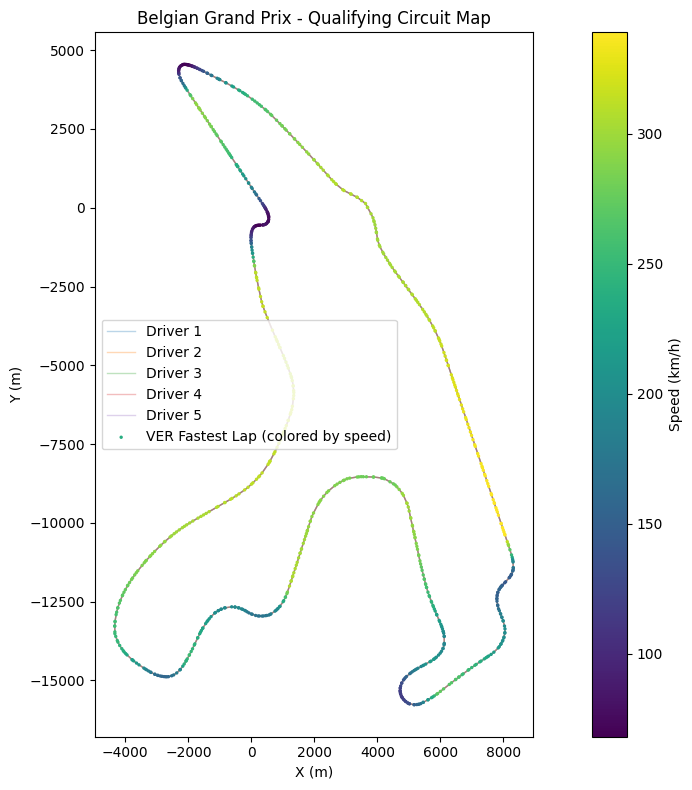


✓ Circuit visualization complete!


In [10]:

import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt

# Enable FastF1 cache - adjust to your cache directory
fastf1.Cache.enable_cache('C:\\Users\\moina\\f1_cache')

year = 2025
event = 'Las Vegas Grand Prix'
session_type = 'Q'  # Qualifying

# Load session data
session = fastf1.get_session(year, event, session_type)
session.load()  # Loads laps, telemetry, etc.

print(f"Session loaded: {session}")
print(f"Session type: {type(session)}")
print(f"Session dir: {[x for x in dir(session) if not x.startswith('_')][:20]}")

# Try to get circuit - look for it in laps or use session attributes
try:
    # Method 1: Get from laps
    if hasattr(session, 'laps') and len(session.laps) > 0:
        print("\n✓ Laps available")
        lap = session.laps.iloc[0]
        print(f"Lap columns: {lap.index.tolist()[:10]}")
    
    # Method 2: Use telemetry which has track coordinates
    fastest_lap = session.laps.pick_fastest()
    telemetry = fastest_lap.get_telemetry()
    
    print(f"\n✓ Telemetry loaded with shape: {telemetry.shape}")
    print(f"Telemetry columns: {telemetry.columns.tolist()}")
    print(f"Telemetry X range: {telemetry['X'].min():.2f} to {telemetry['X'].max():.2f}")
    print(f"Telemetry Y range: {telemetry['Y'].min():.2f} to {telemetry['Y'].max():.2f}")
    
    # Plot the circuit from telemetry data
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all drivers' lap traces to get track outline
    all_telemetry = []
    for driver in session.laps['Driver'].unique()[:5]:  # Sample 5 drivers
        try:
            lap = session.laps.pick_drivers(['VER']).pick_fastest()
            telem = lap.get_telemetry()
            all_telemetry.append(telem)
        except:
            pass
    
    # Plot track from multiple drivers
    for i, telem in enumerate(all_telemetry):
        ax.plot(telem['X'], telem['Y'], alpha=0.3, linewidth=1, label=f'Driver {i+1}')
    
    # Highlight the fastest lap (VER)
    try:
        ver_lap = session.laps.pick_driver('VER').pick_fastest()
        ver_telem = ver_lap.get_telemetry()
        scatter = ax.scatter(ver_telem['X'], ver_telem['Y'], c=ver_telem['Speed'], 
                            cmap='viridis', s=2, label='VER Fastest Lap (colored by speed)', zorder=5)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Speed (km/h)')
    except:
        print("Could not get VER telemetry")
    
    ax.set_aspect('equal')
    ax.set_title(f'Belgian Grand Prix - Qualifying Circuit Map')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Circuit visualization complete!")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()



In [ ]:
# Interactive top-6 qualifying visualizer for Jupyter
# Paste into one cell and run.
# Note: if fastf1 is not installed: pip install fastf1 ipywidgets
# Uploaded local file path (from your session) - keep if you want to load local artifacts:
# UPLOADED_FILE = '/mnt/data/f1code.txt'

import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Adjust cache dir (you can change to your preferred local cache)
CACHE_DIR = r'C:\\Users\\moina\\f1_cache'
fastf1.Cache.enable_cache(CACHE_DIR)

# Helper: pretty time display for lap time (timedelta -> seconds)
def td_to_s(td):
    try:
        return td.total_seconds()
    except:
        return np.nan

# Main loader + plot function
def load_and_plot(year:int, event:str, session_type:str='Q', cmap:str='viridis', show_speed:bool=True):
    out.clear_output(wait=True)
    with out:
        print(f"Loading: {year} {event} {session_type}  —  cache: {CACHE_DIR}")
        try:
            session = fastf1.get_session(year, event, session_type)
        except Exception as e:
            print("Could not find session:", e)
            return
        try:
            # load laps + minimal telemetry on demand (fast)
            session.load(laps=True, telemetry=False, weather=False)  # first load laps quickly
        except Exception as e:
            print("session.load(laps=True) failed:", e)
            return

        # Defensive: ensure qualifying results exist
        if session.results is None or session.results.empty:
            print("No qualifying results found for this session.")
            return

        # Normalize driver id column fallback
        driver_col = None
        for candidate in ['Abbreviation', 'Driver', 'DriverNumber']:
            if candidate in session.results.columns:
                driver_col = candidate
                break
        if driver_col is None:
            print("No driver column in results; can't continue.")
            return

        # Get top-6 by qualifying position (Position/QualifyingPosition)
        pos_col = None
        for c in ['Position','GridPosition','QPos','Q1','Q2','Q3']:
            if c in session.results.columns:
                pos_col = c
                break
        # Prefer 'Position' if present — but many FastF1 qualifying results have Position
        if pos_col is None:
            # fallback: sort by 'Time' in laps per driver
            qual_results = session.results.copy()
            qual_results = qual_results.sort_values(by=qual_results.columns.tolist())  # fallback to original order
            top6 = qual_results.iloc[:6]
        else:
            qual_results = session.results.copy()
            qual_results[pos_col] = pd.to_numeric(qual_results[pos_col], errors='coerce')
            qual_results = qual_results.sort_values(by=pos_col)
            top6 = qual_results.head(6)

        # Build summary table for display
        summary_rows = []
        for _, row in top6.iterrows():
            driver = row[driver_col]
            # pick driver's fastest lap from session.laps
            try:
                driver_laps = session.laps.pick_driver(driver)
                fastest = driver_laps.pick_fastest()
                qtime = fastest['LapTime'] if 'LapTime' in fastest.index else row.get('Time', np.nan)
                s1 = fastest.get('Sector1Time', np.nan)
                s2 = fastest.get('Sector2Time', np.nan)
                s3 = fastest.get('Sector3Time', np.nan)
                qtime_s = td_to_s(qtime) if pd.notna(qtime) else np.nan
            except Exception:
                qtime_s = np.nan; s1 = s2 = s3 = np.nan

            summary_rows.append({
                'Driver': driver,
                'Team': row.get('Team') or row.get('Constructor') or row.get('TeamName', ''),
                'QualPos': int(row.get(pos_col)) if pd.notna(row.get(pos_col)) else np.nan,
                'QualTime_s': qtime_s,
                'S1_s': td_to_s(s1) if pd.notna(s1) else np.nan,
                'S2_s': td_to_s(s2) if pd.notna(s2) else np.nan,
                'S3_s': td_to_s(s3) if pd.notna(s3) else np.nan,
            })

        df_summary = pd.DataFrame(summary_rows).sort_values('QualPos').reset_index(drop=True)
        display(df_summary)

        # Now fetch telemetry for the fastest lap of each of the top-6 (load telemetry per-lap to save time)
        all_telem = []
        for driver in df_summary['Driver']:
            try:
                # careful: pick_driver expects abbreviation or full name depending on dataset; try both
                laps = session.laps.pick_driver(driver)
                if laps.empty:
                    # try using abbreviation column mapping (some versions)
                    candidate = session.laps[session.laps['Driver'].str.contains(driver, na=False)]
                    if candidate.empty:
                        raise ValueError("no laps")
                    laps = candidate
                fastest = laps.pick_fastest()
                # get telemetry for fastest lap (one network read if not cached)
                telem = fastest.get_telemetry()
                telem = telem[['X','Y','Speed']].assign(Driver=driver)
                # sanitize any duplicate points
                telem = telem.dropna(subset=['X','Y']).reset_index(drop=True)
                all_telem.append(telem)
            except Exception as e:
                print(f"Could not get telemetry for {driver}: {e}")

        if not all_telem:
            print("No telemetry available for top-6 fastest laps (maybe telemetry not cached for this session).")
            return

        # Plot overlay traces
        fig, ax = plt.subplots(figsize=(12,8))
        # Plot each driver trace (semi-transparent)
        for telem in all_telem:
            ax.plot(telem['X'], telem['Y'], alpha=0.25, linewidth=1)

        # Optionally scatter fastest-lap points colored by Speed for the primary driver(s)
        if show_speed:
            # overlay speed scatter for each driver (zorder high)
            for telem in all_telem:
                driver = telem['Driver'].iloc[0]
                sc = ax.scatter(telem['X'], telem['Y'], c=telem['Speed'], cmap=cmap, s=4, label=driver, zorder=5)
            cbar = fig.colorbar(sc, ax=ax)
            cbar.set_label('Speed (km/h)')
        else:
            # simple colored markers to distinguish drivers
            colors = plt.cm.tab10.colors
            for i, telem in enumerate(all_telem):
                ax.scatter(telem['X'], telem['Y'], s=6, label=telem['Driver'].iloc[0], color=colors[i % len(colors)], zorder=5)

        ax.set_aspect('equal')
        ax.set_title(f'{year} {event} — Qualifying: Top 6 fastest-lap traces')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
        plt.tight_layout()
        plt.show()

# Widgets
year_w = widgets.IntText(value=2023, description='Year', layout=widgets.Layout(width='200px'))
event_w = widgets.Text(value='Belgian Grand Prix', description='Event', layout=widgets.Layout(width='420px'))
cmap_w = widgets.Dropdown(options=['viridis','plasma','inferno','magma','cividis'], value='viridis', description='Colormap')
show_speed_w = widgets.Checkbox(value=True, description='Show speed color')
load_btn = widgets.Button(description='Load & Plot', button_style='primary')

out = widgets.Output()

def on_load_clicked(b):
    load_and_plot(year_w.value, event_w.value, 'Q', cmap_w.value, show_speed_w.value)

load_btn.on_click(on_load_clicked)

controls = widgets.HBox([year_w, event_w, cmap_w, show_speed_w, load_btn])
display(controls, out)

# Optional: run once with defaults
# on_load_clicked(None)


Output()

In [ ]:
# Advanced Interactive 6-Driver Telemetry Analyzer with Individual Plots
import fastf1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Cache setup
CACHE_DIR = r'C:\Users\moina\f1_cache'
fastf1.Cache.enable_cache(CACHE_DIR)

# ============================================================================
# DATA LOADING & ANALYSIS
# ============================================================================

def load_session_data(year, event, session_type='Q'):
    """Load session and get top 6 drivers with full telemetry"""
    try:
        session = fastf1.get_session(year, event, session_type)
        session.load(laps=True, telemetry=True, weather=False)
        return session
    except Exception as e:
        print(f"❌ Error loading session: {e}")
        return None

def extract_driver_info(session, driver_code):
    """Extract comprehensive telemetry and lap info for a driver"""
    try:
        laps = session.laps.pick_drivers([driver_code])
        if laps.empty:
            return None
        
        fastest = laps.pick_fastest()
        telem = fastest.get_telemetry()
        
        if telem.empty:
            return None
        
        # Get qualifying position from results
        try:
            qual_pos = session.results[session.results['Abbreviation'] == driver_code]['Position'].values[0]
        except:
            qual_pos = 'N/A'
        
        # Get team
        try:
            team = session.results[session.results['Abbreviation'] == driver_code]['TeamName'].values[0]
        except:
            team = 'N/A'
        
        # Calculate telemetry stats
        info = {
            'Driver': driver_code,
            'Team': team,
            'Qualifying_Position': qual_pos,
            'Lap_Time_s': fastest['LapTime'].total_seconds() if pd.notna(fastest['LapTime']) else 0,
            'Top_Speed_kmh': telem['Speed'].max(),
            'Avg_Speed_kmh': telem['Speed'].mean(),
            'Min_Speed_kmh': telem['Speed'].min(),
            'Max_Acceleration_g': telem['Acceleration'].max() if 'Acceleration' in telem.columns else 0,
            'Telemetry_Points': len(telem),
            'Brake_Distance_m': (telem['Speed'].diff().dropna() < 0).sum() if len(telem) > 1 else 0,
        }
        
        return {'info': info, 'telemetry': telem, 'lap': fastest}
    except Exception as e:
        print(f"Error extracting data for {driver_code}: {e}")
        return None

def get_top_6_drivers(session):
    """Get top 6 drivers from qualifying results"""
    try:
        results = session.results.sort_values('Position')
        top_6 = results.head(6)['Abbreviation'].tolist()
        return top_6
    except Exception as e:
        print(f"Error getting top 6: {e}")
        return []

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_driver_circuit(driver_data, ax, cmap='viridis'):
    """Plot individual driver circuit trace with telemetry coloring"""
    telem = driver_data['telemetry']
    driver = driver_data['info']['Driver']
    
    # Scatter plot colored by speed
    scatter = ax.scatter(telem['X'], telem['Y'], c=telem['Speed'], 
                        cmap=cmap, s=8, alpha=0.8, edgecolors='none')
    
    # Add start/end markers
    ax.plot(telem['X'].iloc[0], telem['Y'].iloc[0], 'go', markersize=10, label='Start', zorder=5)
    ax.plot(telem['X'].iloc[-1], telem['Y'].iloc[-1], 'r*', markersize=15, label='End', zorder=5)
    
    ax.set_aspect('equal')
    ax.set_title(f"{driver} - Qualifying Circuit Trace", fontweight='bold', fontsize=12)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.2)
    
    return scatter

def create_info_table(driver_data):
    """Create detailed info table for driver"""
    info = driver_data['info']
    telem = driver_data['telemetry']
    
    table_data = [
        ['<b>DRIVER INFO</b>', ''],
        ['Driver', info['Driver']],
        ['Team', info['Team']],
        ['Qualifying Position', str(info['Qualifying_Position'])],
        ['<b>LAP PERFORMANCE</b>', ''],
        ['Lap Time (s)', f"{info['Lap_Time_s']:.3f}"],
        ['<b>SPEED STATS</b>', ''],
        ['Top Speed (km/h)', f"{info['Top_Speed_kmh']:.1f}"],
        ['Average Speed (km/h)', f"{info['Avg_Speed_kmh']:.1f}"],
        ['Min Speed (km/h)', f"{info['Min_Speed_kmh']:.1f}"],
        ['<b>TELEMETRY DATA</b>', ''],
        ['Total Data Points', str(info['Telemetry_Points'])],
        ['Available Channels', ', '.join(telem.columns.tolist()[:8])],
    ]
    
    return pd.DataFrame(table_data, columns=['Metric', 'Value'])

# ============================================================================
# INTERACTIVE WIDGET
# ============================================================================

# Global state
session_data = None
drivers_data = {}
top_6_drivers = []

def load_session_handler(b):
    """Load session and extract data for top 6"""
    global session_data, drivers_data, top_6_drivers
    
    with output_main:
        output_main.clear_output(wait=True)
        print(f"🔄 Loading {year_input.value} {event_input.value}...")
        
        session_data = load_session_data(year_input.value, event_input.value, 'Q')
        if session_data is None:
            print("❌ Failed to load session")
            return
        
        top_6_drivers = get_top_6_drivers(session_data)
        if not top_6_drivers:
            print("❌ Could not find top 6 drivers")
            return
        
        drivers_data = {}
        print(f"✓ Extracting telemetry for {len(top_6_drivers)} drivers...")
        for driver in top_6_drivers:
            data = extract_driver_info(session_data, driver)
            if data:
                drivers_data[driver] = data
                print(f"  ✓ {driver}")
            else:
                print(f"  ❌ {driver}")
        
        # Update driver selector
        driver_select.options = list(drivers_data.keys())
        if drivers_data:
            driver_select.value = list(drivers_data.keys())[0]
        
        print(f"\n✓ Loaded {len(drivers_data)} drivers successfully!")

def driver_changed(change):
    """Handle driver selection change"""
    display_driver_analysis(driver_select.value)

def display_driver_analysis(driver_code):
    """Display circuit plot + telemetry info for selected driver"""
    with output_analysis:
        output_analysis.clear_output(wait=True)
        
        if driver_code not in drivers_data:
            print("No data for this driver")
            return
        
        driver_data = drivers_data[driver_code]
        
        # Create subplot layout
        fig = plt.figure(figsize=(16, 6))
        gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)
        
        # Left: Circuit plot
        ax_circuit = fig.add_subplot(gs[0])
        scatter = plot_driver_circuit(driver_data, ax_circuit, cmap=colormap_select.value)
        cbar = plt.colorbar(scatter, ax=ax_circuit, label='Speed (km/h)')
        
        # Display
        plt.tight_layout()
        plt.show()
        
        # Display info table
        print("\n" + "="*60)
        print(f"DETAILED TELEMETRY ANALYSIS: {driver_code}")
        print("="*60)
        
        info_table = create_info_table(driver_data)
        display(HTML(info_table.to_html(index=False, border=0)))
        
        # Additional telemetry channels info
        telem = driver_data['telemetry']
        print(f"\n📊 TELEMETRY CHANNELS AVAILABLE ({len(telem.columns)}):")
        print("-" * 60)
        for i, col in enumerate(telem.columns, 1):
            if pd.api.types.is_numeric_dtype(telem[col]):
                val_range = f"[{telem[col].min():.2f}, {telem[col].max():.2f}]"
                print(f"  {i}. {col:20s} {val_range:>30s}")
            else:
                print(f"  {i}. {col}")

# ============================================================================
# UI COMPONENTS
# ============================================================================

year_input = widgets.IntText(
    value=2024,
    description='Year:',
    layout=widgets.Layout(width='150px')
)

event_input = widgets.Text(
    value='Monaco Grand Prix',
    description='Event:',
    layout=widgets.Layout(width='300px')
)

colormap_select = widgets.Dropdown(
    options=['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool', 'hot'],
    value='viridis',
    description='Colormap:',
    layout=widgets.Layout(width='200px')
)

load_btn = widgets.Button(
    description='Load Session',
    button_style='success',
    layout=widgets.Layout(width='150px')
)

driver_select = widgets.Dropdown(
    options=[],
    description='Driver:',
    layout=widgets.Layout(width='200px')
)

# Connect event handlers
load_btn.on_click(load_session_handler)
driver_select.observe(driver_changed, names='value')
colormap_select.observe(lambda change: display_driver_analysis(driver_select.value), names='value')

# Layout
controls_top = widgets.HBox([year_input, event_input, load_btn], layout=widgets.Layout(gap='10px'))
controls_select = widgets.HBox([driver_select, colormap_select], layout=widgets.Layout(gap='10px'))
all_controls = widgets.VBox([controls_top, controls_select], layout=widgets.Layout(gap='10px'))

output_main = widgets.Output()
output_analysis = widgets.Output()

# Display
display(all_controls)
display(output_main)
display(output_analysis)

print("✓ Interactive 6-Driver Telemetry Analyzer Ready!")
print("  1. Enter year and event name")
print("  2. Click 'Load Session'")
print("  3. Select driver from dropdown to view circuit trace & telemetry info")
print("  4. Change colormap to visualize different aspects of telemetry")

Output()

Output()

✓ Interactive 6-Driver Telemetry Analyzer Ready!
  1. Enter year and event name
  2. Click 'Load Session'
  3. Select driver from dropdown to view circuit trace & telemetry info
  4. Change colormap to visualize different aspects of telemetry


: 